In [1]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from Unet import *
from DiffusionModel import *

In [2]:
# define hyperparameters

image_size = 32
channel = 1

batchsize = 128

timestep = 300

lr = 1e-3
epochs = 1

dimmults = (1,2,4,8)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)

cuda:0


In [3]:
# get MNIST datasets

data_root = './data'

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
])

train_set = datasets.MNIST(
    root=data_root, train=True, download=True, transform=transform
)

data_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True)

In [4]:
# define linear beta schedule

linear_betas, linear_alphas, linear_sqrt_alphas, linear_sqrt_one_minus_alphas, linear_sampling_1, linear_sampling_2 = total_beta_schedule(linear_beta_schedule, timestep)

# define linear network and optimizer_linear

linear_net = Unet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
linear_net.to(device)

linear_optimizer = optim.Adam(linear_net.parameters(), lr=lr)

In [5]:
# train - linear

linear_training_loss, linear_training_taken_step, linear_taken_step = training(data_loader, epochs, timestep, linear_net, linear_optimizer, device, 
                                                                               linear_sqrt_alphas, linear_sqrt_one_minus_alphas)


>> epoch : 0
Loss:  0.07541263103485107
Loss:  0.05776310712099075
Loss:  0.043095462024211884
Loss:  0.039347998797893524


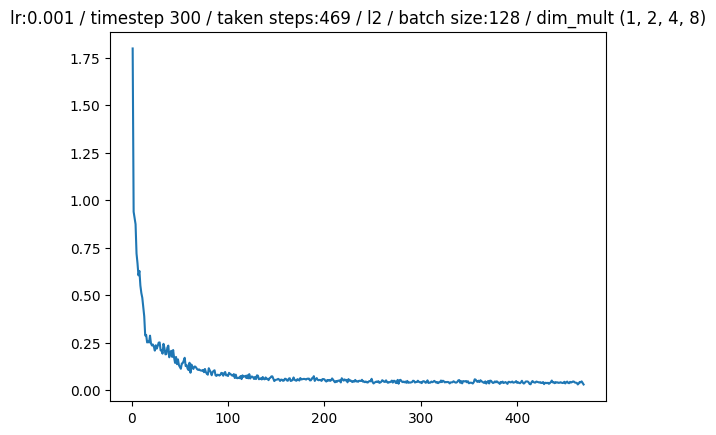

In [6]:
# plot loss linear 

x = np.array(linear_training_taken_step)
y = np.array([x.cpu().detach().numpy() for x in linear_training_loss])

plt.plot(x, y)
plt.title(f"lr:{lr} / timestep {timestep} / taken steps:{linear_taken_step} / l2 / batch size:{batchsize} / dim_mult {dimmults}")
plt.show()

In [7]:
# save linear model
save_net_betas(linear_net, 
               linear_betas, 
               linear_alphas,
               linear_sqrt_alphas,
               linear_sqrt_one_minus_alphas,
               linear_sampling_1, 
               linear_sampling_2, 
               "linear_abstract")

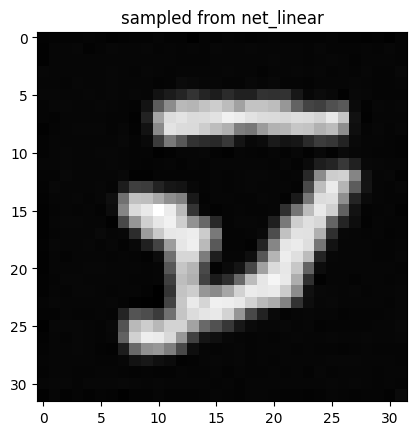

In [8]:
# plot sampled image - linear

res:torch.Tensor = sampling(timestep, linear_betas, linear_sampling_1, linear_sampling_2, linear_net, device)

plt.figure()
plt.title("sampled from net_linear")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')

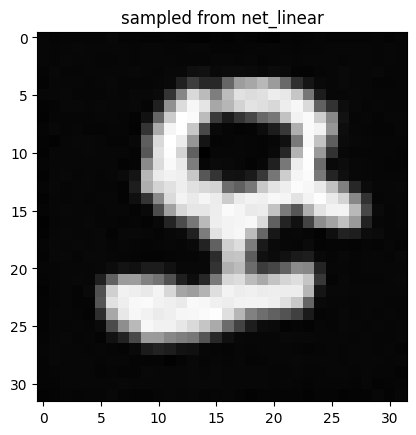

In [9]:
# sample from loaded models

loaded_linear_net = Unet(
    dim=image_size,
    channels=channel,
    dim_mults=dimmults
)
loaded_linear_net, loaded_linear_betas, loaded_linear_sampling_1, loaded_linear_sampling_2 = load_net_betas(loaded_linear_net, device, "linear_abstract")


res:torch.Tensor = sampling(timestep, loaded_linear_betas, loaded_linear_sampling_1, loaded_linear_sampling_2, loaded_linear_net, device)

plt.figure()
plt.title("sampled from net_linear")
plt.imshow(res.cpu().detach().numpy()[0].reshape(32,32), cmap='gray')